In [1]:
import pandas as pd
import os
import xarray as xr
from tqdm import tqdm
import altair as alt
import numpy as np

In [2]:
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

In [4]:
ds = xr.open_dataset(os.path.join(kps_download_dir, file_list[0]))
ds['h2o_licor'].plot

In [5]:
# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])

100%|██████████| 646/646 [00:35<00:00, 18.23it/s]


In [6]:
from sublimpy import utils

In [7]:
mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')

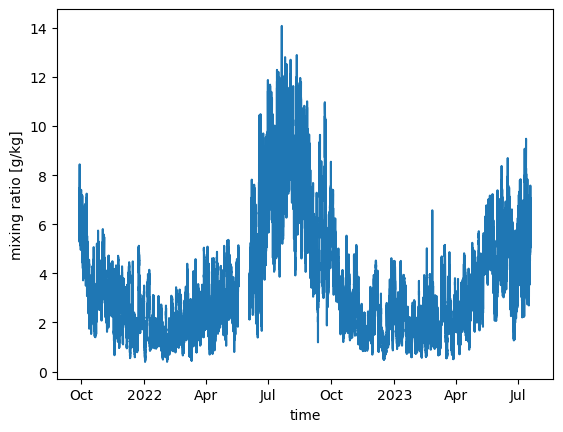

In [8]:
mixingratio_ds.plot()

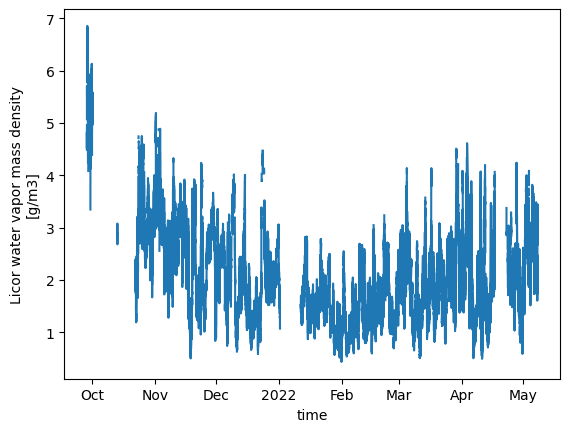

In [9]:
abshum_ds.plot()

In [10]:
heights = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
start_date = '20221101'
end_date = '20230619'
    # streamwise-coords
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope-adjusted earthwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # sonic coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

In [11]:
tidy_df = tidy_df.set_index('time').sort_index().reset_index()

## Compare IRGA and Hygrometer measurements

In [12]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

measurement                       Water vapor density (irga)  air density  \
time                height tower                                            
2022-10-31 18:00:00 0.0    c                             NaN     0.929379   
                           d                             NaN     0.921632   
                    1.0    c                        2.701510     0.916267   
                           d                        2.511889          NaN   
                           ue                       2.323081          NaN   
...                                                      ...          ...   
2023-06-19 17:30:00 16.0   c                             NaN     0.858220   
                    17.0   c                             NaN     0.858006   
                    18.0   c                             NaN     0.857962   
                    19.0   c                             NaN     0.858107   
                    20.0   c                        0.627670     0.857857   

measurement                       specific humidity  \
time                height tower                      
2022-10-31 18:00:00 0.0    c               3.895127   
                           d                    NaN   
                    1.0    c               2.983229   
                           d                    NaN   
                           ue                   NaN   
...                                             ...   
2023-06-19 17:30:00 16.0   c               3.041327   
                    17.0   c               2.999553   
                    18.0   c               2.988210   
                    19.0   c               2.995862   
                    20.0   c               2.979198   

measurement                       Water vapor density (hygr)  
time                height tower                              
2022-10-31 18:00:00 0.0    c                        3.620051  
                           d                             NaN  
                    1.0    c                        2.733436  
                           d                             NaN  
                           ue                            NaN  
...                                                      ...  
2023-06-19 17:30:00 16.0   c                        2.610127  
                    17.0   c                        2.573635  
                    18.0   c                        2.563771  
                    19.0   c                        2.570770  
                    20.0   c                        2.555726  

[311246 rows x 4 columns]

In [13]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [14]:
import math 

src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values

from sklearn.metrics import r2_score
meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') | r2_plot(6, 'June')
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)

alt.VConcatChart(...)

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [15]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [16]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [17]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.524960,2.487768,0.037192
1,h2o_10m_d,d,10.0,1.777380,2.487768,-0.710388
2,h2o_10m_ue,ue,10.0,1.466664,2.487768,-1.021105
3,h2o_10m_uw,uw,10.0,2.096750,2.487768,-0.391018
4,h2o_15m_c,c,15.0,2.291071,2.466526,-0.175455
5,h2o_1m_c,c,1.0,2.839837,2.644184,0.195654
6,h2o_1m_d,d,1.0,2.036135,2.644184,-0.608049
7,h2o_1m_ue,ue,1.0,2.150419,2.644184,-0.493765
8,h2o_1m_uw,uw,1.0,2.426378,2.644184,-0.217805
9,h2o_20m_c,c,20.0,1.256475,2.452869,-1.196394


Update dataset with corrections

In [18]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
27,2022-10-31 18:00:00,h2o_10m_ue,1.805038,10.0,ue,Water vapor density
47,2022-10-31 18:00:00,h2o_1m_ue,2.323081,1.0,ue,Water vapor density
89,2022-10-31 18:00:00,h2o_3m_c,2.547044,3.0,c,Water vapor density
148,2022-10-31 18:00:00,h2o_1m_c,2.701510,1.0,c,Water vapor density
192,2022-10-31 18:00:00,h2o_10m_c,2.727012,10.0,c,Water vapor density
...,...,...,...,...,...,...
9590654,2023-06-19 17:30:00,h2o_3m_d,3.101750,3.0,d,Water vapor density
9590676,2023-06-19 17:30:00,h2o_10m_d,2.669686,10.0,d,Water vapor density
9590686,2023-06-19 17:30:00,h2o_3m_c,2.461334,3.0,c,Water vapor density
9590788,2023-06-19 17:30:00,h2o_1m_uw,3.362670,1.0,uw,Water vapor density


In [19]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [20]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [21]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [22]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [23]:
HEIGHTS = [3,10]

# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = round(
    dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/3338630004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/3338630004.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                   3.0                                     10.0  \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-10-31 18:00:00  0.003159  0.003063  0.003192  0.003134  0.002954   
2022-10-31 18:30:00  0.003199  0.003095  0.003207  0.003170  0.003037   
2022-10-31 19:00:00  0.003133  0.003038  0.003162  0.003109  0.002961   
2022-10-31 19:30:00  0.003086  0.002992  0.003111  0.003076  0.002947   
2022-10-31 20:00:00  0.003095  0.002989  0.003104  0.003076  0.002957   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003053  0.003760  0.003523  0.003545  0.002725   
2023-06-19 16:00:00  0.003414  0.004059  0.003875  0.004034  0.002934   
2023-06-19 16:30:00  0.003241  0.003825  0.003660  0.003767  0.002893   
2023-06-19 17:00:00  0.003364  0.003995  0.003809  0.003882  0.002936   
2023-06-19 17:30:00  0.003261  0.003985  0.003790  0.003740  0.003035   

height                                             
tower                       d        ue        uw  
measurement                 r         r         r  
time                                               
2022-10-31 18:00:00  0.002910  0.003104  0.003022  
2022-10-31 18:30:00  0.002959  0.003154  0.003076  
2022-10-31 19:00:00  0.002886  0.003070  0.002998  
2022-10-31 19:30:00  0.002874  0.003044  0.002993  
2022-10-31 20:00:00  0.002873  0.003047  0.003001  
...                       ...       ...       ...  
2023-06-19 15:30:00  0.003754  0.003497  0.004366  
2023-06-19 16:00:00  0.003866  0.003648  0.004471  
2023-06-19 16:30:00  0.003778  0.003565  0.004364  
2023-06-19 17:00:00  0.003841  0.003670  0.004412  
2023-06-19 17:30:00  0.003930  0.003804  0.004488  

[11062 rows x 8 columns]

In [24]:
# this is created in the flux_divergence_3d_numerical_pawu.ipynb notebook
src = pd.read_csv('irga_mixingratio_estimates.csv')
src.time = pd.to_datetime(src.time)
from sublimpy import utils
src.value = src.value*1000
src = src.set_index('time')

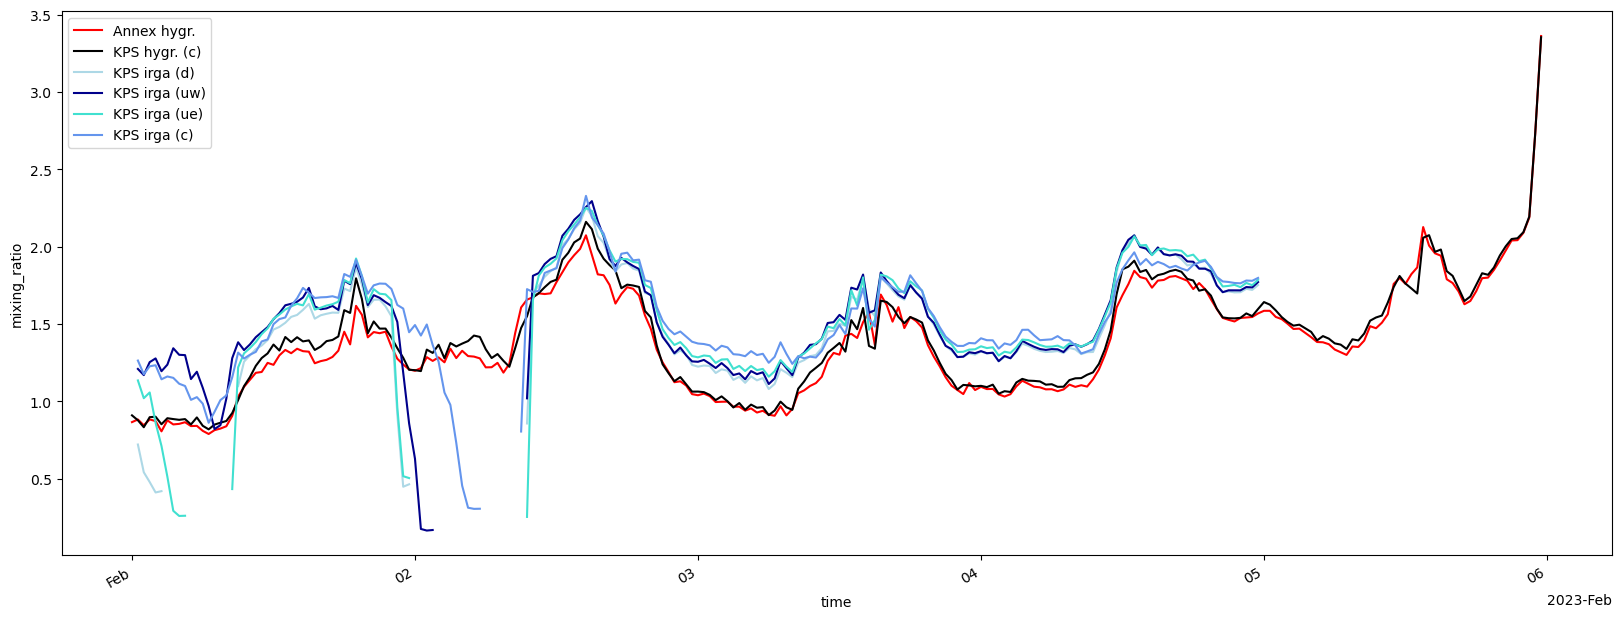

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230201', '20230205')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230201': '20230205']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()

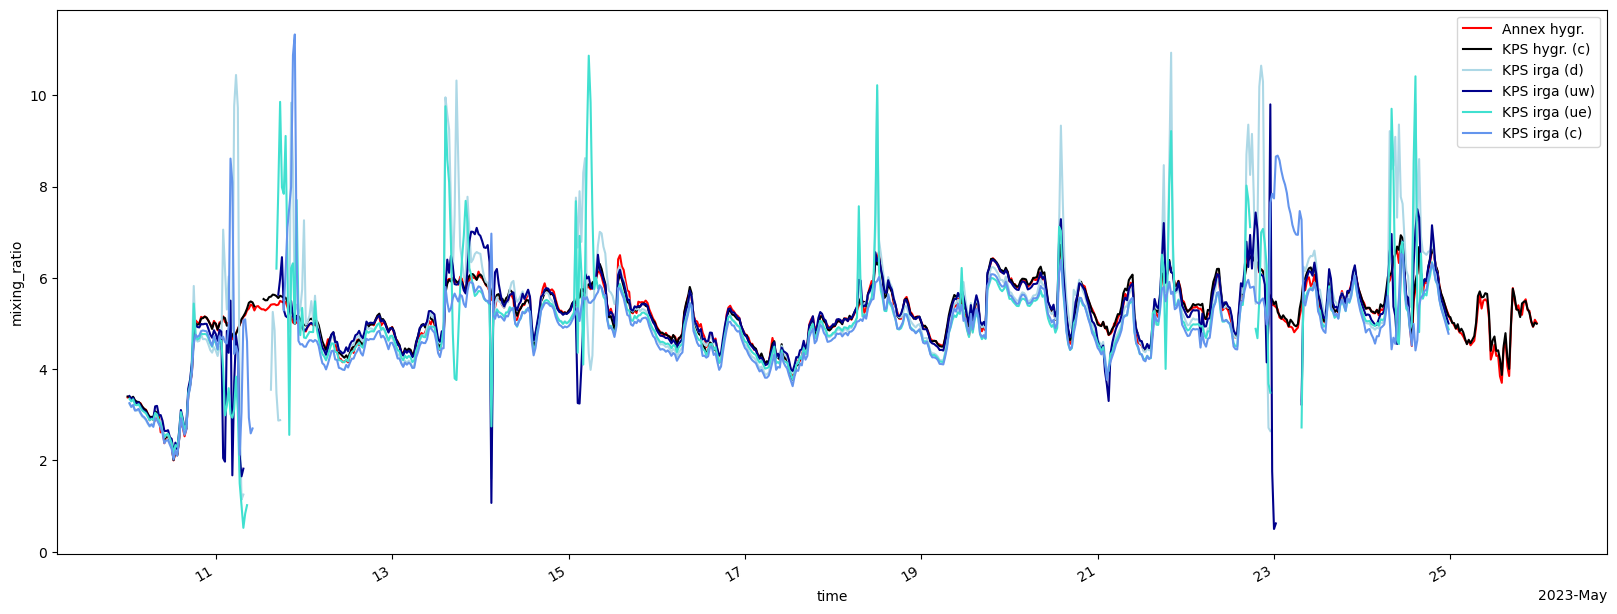

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230510', '20230525')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230510': '20230525']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')

src = mixing_ratio_field_df.copy()
src.columns = src.columns.droplevel(2)
src.columns = [f"{int(c1)}_{c2}" for (c1,c2) in zip(
    src.columns.get_level_values(0),
    src.columns.get_level_values(1)
)]
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('_')[0]))
src['tower'] = src['variable'].apply(lambda s: s.split('_')[1])
src = src.reset_index()
src = src[(src.time > '20230510') & (src.time < '20230525')]
src = src.query("height == 3")

(1000*src.query("tower == 'd'").set_index('time')['value']).plot(ax=ax, label='KPS irga (d)', color='lightblue')
(1000*src.query("tower == 'uw'").set_index('time')['value']).plot(ax=ax, label='KPS irga (uw)', color='darkblue')
(1000*src.query("tower == 'ue'").set_index('time')['value']).plot(ax=ax, label='KPS irga (ue)', color='turquoise')
(1000*src.query("tower == 'c'").set_index('time')['value']).plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')

plt.legend()

Text(0, 0.5, 'mixing ration [g/kg]')

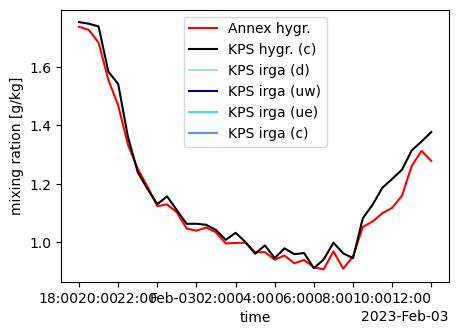

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20230202 1800','20230203 1200')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20230202 1800':'20230203 1200']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.sort_index().loc['20230202 1800':'20230203 1200'].query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()
plt.ylabel('mixing ration [g/kg]')

In [28]:
# this is created in the flux_divergence_3d_numerical_pawu.ipynb notebook
src = pd.read_csv('irga_mixingratio_estimates_2.csv')
src.time = pd.to_datetime(src.time)
from sublimpy import utils
src.value = src.value*1000
src = src.set_index('time')

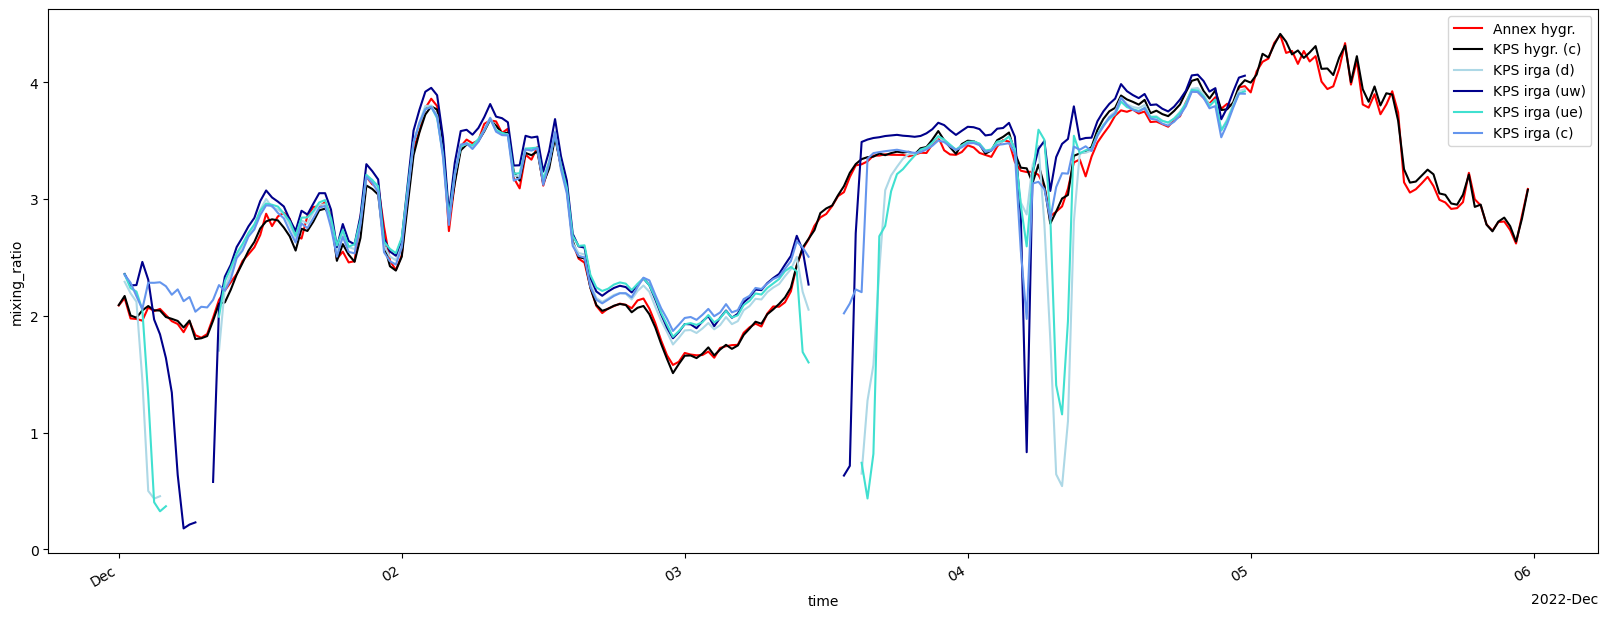

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
mixingratio_ds.to_dataframe().sort_index().to_xarray().sel(time=slice('20221201', '20221205')).resample(time='30min').mean()['mixing_ratio'].plot(ax=ax, label='Annex hygr.', color='red')
(tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc['20221201': '20221205']['value']*1000).plot(ax=ax, label='KPS hygr. (c)', color='black')
src.query("tower == 'd'")['value'].plot(ax=ax, label='KPS irga (d)', color='lightblue')
src.query("tower == 'uw'")['value'].plot(ax=ax, label='KPS irga (uw)', color='darkblue')
src.query("tower == 'ue'")['value'].plot(ax=ax, label='KPS irga (ue)', color='turquoise')
src.query("tower == 'c'")['value'].plot(ax=ax, label='KPS irga (c)', color='cornflowerblue')
plt.legend()

<Axes: xlabel='time'>

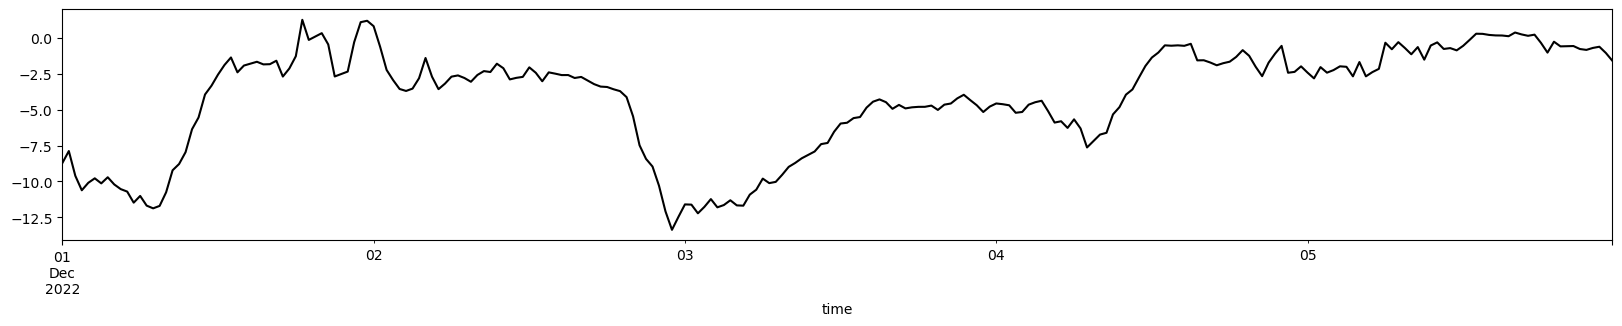

In [30]:
fig, ax = plt.subplots(figsize=(20,3))
# (tidy_df.query("variable == 'RH_3m_c'").set_index('time').loc['20221201': '20221205']['value']*1000).plot(label='KPS hygr. (c)', color='black')
(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20221201': '20221205']['value']).plot(ax=ax, label='KPS hygr. (c)', color='black')

In [31]:
import metpy.calc
from metpy.units import units

metpy.calc.mixing_ratio_from_relative_humidity(
    0.8*units('atm'),
    -10*units('celsius'),
    50*units('percent')
)*1000

<Quantity(1.10211188, 'dimensionless')>

# Scaling analysis (for 1D advection)

## Horizontal advection using KPS and Annex hygrometer measurements

In [32]:
# combine mixing ration measurements from the two sites
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('kps')
kps_vs_annex_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)

# # Add wind dir variable
kps_vs_annex_df = kps_vs_annex_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_vs_annex_df = kps_vs_annex_df[
    ((kps_vs_annex_df.dir_10m_c >= 100) & (kps_vs_annex_df.dir_10m_c <= 140))
    |
    ((kps_vs_annex_df.dir_10m_c >= 300) & (kps_vs_annex_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_vs_annex_df['direction'] = kps_vs_annex_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')

# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_vs_annex_df['ds'] = kps_vs_annex_df.apply(
    lambda row: row['annex'] - row['kps'] if row['direction'] == 'down' else row['kps'] - row['annex'],
    axis=1
)

kps_vs_annex_df['dx'] = 400
kps_vs_annex_df['ds/dx'] = kps_vs_annex_df['ds'] / kps_vs_annex_df['dx']

# # Add other variables from KPS
kps_vs_annex_df = kps_vs_annex_df.join(
    tidy_df.query("variable == 'spd_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('u')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)

kps_vs_annex_df.dropna()

,annex,kps,dir_10m_c,direction,ds,dx,ds/dx,u,rho,w_h2o__3m_c
time,,,,,,,,,,
2022-11-01 00:30:00,0.002840,0.002817,317.077209,down,0.000023,400,5.664100e-08,2.563384,933.485270,-0.000107
2022-11-01 01:00:00,0.002794,0.002738,304.689484,down,0.000056,400,1.405851e-07,2.125042,938.457131,-0.000696
2022-11-01 01:30:00,0.002810,0.002737,310.308075,down,0.000073,400,1.837235e-07,2.380683,938.780129,-0.000560
2022-11-01 02:00:00,0.002753,0.002721,313.789551,down,0.000032,400,7.935829e-08,2.812759,939.538717,-0.001403
2022-11-01 02:30:00,0.002763,0.002702,310.939148,down,0.000061,400,1.522928e-07,3.197397,941.148043,-0.000559
...,...,...,...,...,...,...,...,...,...,...
2023-06-19 14:00:00,0.003479,0.003503,321.372681,down,-0.000024,400,-6.058010e-08,5.295882,862.134695,0.172137
2023-06-19 15:30:00,0.003263,0.003308,319.240662,down,-0.000045,400,-1.114288e-07,3.498414,860.401869,0.147933
2023-06-19 16:00:00,0.003561,0.003714,314.099487,down,-0.000153,400,-3.823352e-07,4.816846,860.601842,0.128144


In [33]:
kps_vs_annex_df['ds/dx'].median()

-1.2852011354433282e-08

$$\large \overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$$

In [34]:
kps_vs_annex_df['lateral_advection'] = kps_vs_annex_df['u'] * kps_vs_annex_df['rho'] * kps_vs_annex_df['ds/dx']

In [35]:
kps_vs_annex_df['u'].mean(), kps_vs_annex_df['rho'].mean(), kps_vs_annex_df['ds/dx'].mean(), kps_vs_annex_df['lateral_advection'].mean()

(3.289176680952293,
 933.5372332536306,
 -1.14303392591663e-08,
 -7.614465561004246e-05)

In [36]:
kps_vs_annex_df = kps_vs_annex_df.sort_index()

In [37]:
src

,Unnamed: 0,variable,value,height,tower
time,,,,,
2022-12-01 00:30:00,30705,3_c,2.349799,3,c
2022-12-01 01:00:00,30706,3_c,2.283458,3,c
2022-12-01 01:30:00,30707,3_c,2.168240,3,c
2022-12-01 02:00:00,30708,3_c,2.057494,3,c
2022-12-01 02:30:00,30709,3_c,2.282858,3,c
...,...,...,...,...,...
2022-12-04 21:30:00,53883,3_uw,3.682283,3,uw
2022-12-04 22:00:00,53884,3_uw,3.781070,3,uw
2022-12-04 22:30:00,53885,3_uw,3.916054,3,uw


In [38]:
import altair as alt
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
src = src.set_index('time').sort_index().loc['20230201':'20230206']
alt.Chart(
    src.reset_index()
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(width = 800).configure_legend(orient='top', labelFontSize=16)

alt.Chart(...)

In [39]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [40]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

In [41]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vs_annex_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

alt.Chart(...)

Assume a 1D equation for advective divergence.

$\overline{u} \space \overline{\rho} \frac{\partial s}{\partial x}$

For the night of Feb 2nd approximately:
* a 0.2 difference in the mixing ratio ($s$) between the two sites ($\Delta s \approx 0.2$ g/kg $\approx 0.0002$ g/g)
* The sites are about 500 meters apart ($\Delta x \approx  500$ meters)
* Wind speed could be 1-2 meters ($\overline{u} \approx 1$)
* Density could be about 960 g/m $^3$

So our advective term might equal:

$1 (m/s) * 960 g/m^3 * 0.0002 / 500 m$

This results in about $0.0003$ g/m^3/s, or, multiplying by the height of our site to get a flux density, 7m, 0.002-0.003 g/m^2/s

## Vertical advection using KPS hygrometer measurements

### Simple scaling

In [42]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_10m_c')
kps_vert_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_df['ds'] = kps_vert_df['mixingratio_10m_c'] - kps_vert_df['mixingratio_3m_c']
kps_vert_df['dz'] = 7
kps_vert_df['ds/dz'] = kps_vert_df['ds'] / kps_vert_df['dz']

kps_vert_df = kps_vert_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)
kps_vert_df['vertical_advection'] =  kps_vert_df['w'] * kps_vert_df['rho'] * kps_vert_df['ds/dz']
kps_vert_df

,mixingratio_3m_c,mixingratio_10m_c,ds,dz,ds/dz,w,rho,w_h2o__3m_c,vertical_advection
time,,,,,,,,,
2022-11-01 00:00:00,0.002826,0.002799,-0.000027,7,-3.823877e-06,0.029986,932.578743,-0.000168,-0.000107
2022-11-01 00:30:00,0.002817,0.002822,0.000005,7,6.762732e-07,0.015964,931.546211,-0.000107,0.000010
2022-11-01 01:00:00,0.002738,0.002760,0.000022,7,3.170921e-06,-0.005672,936.657906,-0.000696,-0.000017
2022-11-01 01:30:00,0.002737,0.002793,0.000056,7,7.983929e-06,-0.018666,936.760664,-0.000560,-0.000140
2022-11-01 02:00:00,0.002721,0.002753,0.000032,7,4.590722e-06,-0.027181,938.091874,-0.001403,-0.000117
...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,0.003308,0.002854,-0.000454,7,-6.481340e-05,-0.021746,861.135781,0.147933,0.001214
2023-06-19 16:00:00,0.003714,0.003102,-0.000612,7,-8.748309e-05,-0.018157,861.083448,0.128144,0.001368
2023-06-19 16:30:00,0.003542,0.003064,-0.000478,7,-6.829598e-05,-0.021679,860.462070,0.112471,0.001274


In [43]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

In [44]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N'),
    alt.Facet('month(time):T').sort(['Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'])
).properties(width = 200, height = 200)

alt.Chart(...)

In [45]:
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('height:O').scale(scheme='sinebow'),
    alt.Row('tower:N'),
    tooltip='height',
).properties(width = 200, height = 200, title='Vertical wind speed') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'mixingratio_10m_c', 'mixingratio_15m_c', 'mixingratio_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor mixing ratio (g/g)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='Hygrometer mixing ratio') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['h2o_2m_c', 'h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c', 'h2o_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Absolute humidity (g/m^3)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='IRGA absolute humidity')

alt.HConcatChart(...)

### Numerical

In [46]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

vertical_advection_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection': vert_adv_ls
})

vertical_advection_df = pd.DataFrame(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
).join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'Ri_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('Ri_3m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    tidy_df.query("variable == 'tke_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('tke_3m_c')
).join(
    vertical_advection_df.set_index('time')
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/2792014789.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/2792014789.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/2792014789.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_96794/2792014789.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame i

In [47]:
alt.Chart(
    vertical_advection_df.reset_index()
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

In [48]:
import altair as alt
alt.Chart(
    vertical_advection_df.loc['20221221 0600':'20221223'].reset_index()
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c', 'w_h2o__10m_c']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Water vapor density flux (g/m^2/s)'),
    alt.Color('key:N'),

).properties(width = 400, height = 200).configure_legend(orient='top').resolve_scale(color='independent').display(renderer='svg')

alt.Chart(...)

In [49]:
(
    (alt.Chart(
        vertical_advection_df.loc['20230201':'20230205'].reset_index()
    ).transform_fold(
        ['vertical_advection', 'w_h2o__3m_c', 'w_h2o__10m_c']
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor density flux (g/m^2/s)'),
        alt.Color('key:N'),
    ).properties(width = 400, height = 200) 
    |
    alt.Chart(
        vertical_advection_df.loc['20230201':'20230205'].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('dir_10m_c:Q').scale(domain=[0,360]),
    ).properties(width = 400, height = 200))
    &
    (alt.Chart(
        vertical_advection_df.loc['20230201':'20230205'].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('spd_3m_c:Q'),
    ).properties(width = 400, height = 200)
    |
    alt.Chart(
        vertical_advection_df.loc['20230201':'20230205'].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('tke_3m_c:Q'),
    ).properties(width = 400, height = 200)
    )

).configure_legend(orient='top').resolve_scale(color='independent').display(renderer='svg')

alt.VConcatChart(...)

## Horizontal advection using KPS gas analyzer measurements

In [50]:
import pandas as pd

In [51]:
mixing_ratio_field_df = pd.read_pickle('mixing_ratio_field_df.pkl')
mixing_ratio_field_df


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002549  0.003118  0.002698  0.002963  0.003059   
2022-11-01 00:30:00  0.002517  0.003095  0.002652  0.002970  0.003034   
2022-11-01 01:00:00  0.002515  0.003095  0.002649  0.002940  0.003029   
2022-11-01 01:30:00  0.002483  0.003066  0.002616  0.002903  0.003002   
2022-11-01 02:00:00  0.002475  0.003061  0.002600  0.002902  0.002989   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003720  0.003361  0.004513  0.004320  0.003053   
2023-06-19 16:00:00  0.004113  0.003610  0.004872  0.004665  0.003414   
2023-06-19 16:30:00  0.003805  0.003244  0.004496  0.004210  0.003242   
2023-06-19 17:00:00  0.003976  0.003396  0.004675  0.004311  0.003365   
2023-06-19 17:30:00  0.003820  0.003341  0.004591  0.004163  0.003261   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002902  0.003019  0.003013  0.002987  0.002827   
2022-11-01 00:30:00  0.002884  0.003009  0.002992  0.002986  0.002830   
2022-11-01 01:00:00  0.002860  0.002979  0.002969  0.002971  0.002796   
2022-11-01 01:30:00  0.002832  0.002951  0.002931  0.002958  0.002794   
2022-11-01 02:00:00  0.002819  0.002936  0.002927  0.002930  0.002763   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003761  0.003523  0.003545  0.002726  0.003754   
2023-06-19 16:00:00  0.004059  0.003875  0.004034  0.002934  0.003866   
2023-06-19 16:30:00  0.003825  0.003661  0.003767  0.002893  0.003778   
2023-06-19 17:00:00  0.003995  0.003809  0.003882  0.002936  0.003841   
2023-06-19 17:30:00  0.003985  0.003791  0.003741  0.003035  0.003930   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-01 00:00:00  0.003009  0.002989  
2022-11-01 00:30:00  0.002984  0.002996  
2022-11-01 01:00:00  0.002973  0.002961  
2022-11-01 01:30:00  0.002951  0.002963  
2022-11-01 02:00:00  0.002928  0.002934  
...                       ...       ...  
2023-06-19 15:30:00  0.003497  0.004367  
2023-06-19 16:00:00  0.003649  0.004471  
2023-06-19 16:30:00  0.003565  0.004364  
2023-06-19 17:00:00  0.003671  0.004413  
2023-06-19 17:30:00  0.003804  0.004488  

[11051 rows x 12 columns]

In [52]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_df = pd.DataFrame(upwind_s)
kps_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_df = kps_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_df = kps_df[
    ((kps_df.dir_10m_c >= 100) & (kps_df.dir_10m_c <= 140))
    |
    ((kps_df.dir_10m_c >= 300) & (kps_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_df['direction'] = kps_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_df['ds'] = kps_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_df['dx'] = 32
kps_df['ds/dx'] = kps_df['ds'] / kps_df['dx']
kps_df = kps_df.join(
    tidy_df.query("variable == 'u_3m_c'").set_index('time')['value'].rename('u')
)
kps_df = kps_df.join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
)
kps_df = kps_df.join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)
kps_df['lateral_advection'] = kps_df['u'] * kps_df['rho'] * kps_df['ds/dx']
kps_df

,upwind_s,downwind_s,dir_10m_c,direction,ds,dx,ds/dx,u,rho,w_h2o__3m_c,lateral_advection
time,,,,,,,,,,,
2022-11-01 00:30:00,0.003000,0.002884,317.077209,down,-0.000116,32,-0.000004,1.181161,933.485270,-0.000107,-0.003994
2022-11-01 01:00:00,0.002974,0.002860,304.689484,down,-0.000114,32,-0.000004,0.996834,938.457131,-0.000696,-0.003319
2022-11-01 01:30:00,0.002941,0.002832,310.308075,down,-0.000110,32,-0.000003,1.434424,938.780129,-0.000560,-0.004612
2022-11-01 02:00:00,0.002931,0.002819,313.789551,down,-0.000113,32,-0.000004,1.532033,939.538717,-0.001403,-0.005075
2022-11-01 02:30:00,0.002915,0.002806,310.939148,down,-0.000110,32,-0.000003,1.488230,941.148043,-0.000559,-0.004807
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 14:00:00,0.003749,0.003851,321.372681,down,0.000102,32,0.000003,1.524000,862.134695,0.172137,0.004208
2023-06-19 15:30:00,0.003534,0.003761,319.240662,down,0.000227,32,0.000007,0.242548,860.401869,0.147933,0.001477
2023-06-19 16:00:00,0.003955,0.004059,314.099487,down,0.000104,32,0.000003,2.716993,860.601842,0.128144,0.007603


In [53]:

import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_df.copy()
src = (src.assign(lateral_advection= 7*src.lateral_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['lateral_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N'),
).properties(width = 200, height = 200)

alt.Chart(...)

## Vertical advection using KPS gas analyzer measurements

In [54]:
src3m = mixing_ratio_field_df[3, 'c', 'r'] 
src3m.name = 'mixing ratio 3m'
src10m = mixing_ratio_field_df[10, 'c', 'r']
src10m.name = 'mixing ratio 10m'
kps_vert_irga_df = pd.DataFrame(src3m).join(src10m)
kps_vert_irga_df['ds'] = kps_vert_irga_df['mixing ratio 10m'] - kps_vert_irga_df['mixing ratio 3m']
kps_vert_irga_df['dz'] = 7
kps_vert_irga_df['ds/dz'] = kps_vert_irga_df['ds'] / kps_vert_irga_df['dz']

kps_vert_irga_df = kps_vert_irga_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')   
)
kps_vert_irga_df['vertical_advection'] =  kps_vert_irga_df['w'] * kps_vert_irga_df['rho'] * kps_vert_irga_df['ds/dz']

kps_vert_irga_df

,mixing ratio 3m,mixing ratio 10m,ds,dz,ds/dz,w,rho,w_h2o__3m_c,vertical_advection
time,,,,,,,,,
2022-11-01 00:00:00,0.003059,0.002987,-0.000072,7,-0.000010,0.029986,932.578743,-0.000168,-0.000288
2022-11-01 00:30:00,0.003034,0.002986,-0.000048,7,-0.000007,0.015964,931.546211,-0.000107,-0.000102
2022-11-01 01:00:00,0.003029,0.002971,-0.000058,7,-0.000008,-0.005672,936.657906,-0.000696,0.000044
2022-11-01 01:30:00,0.003002,0.002958,-0.000043,7,-0.000006,-0.018666,936.760664,-0.000560,0.000109
2022-11-01 02:00:00,0.002989,0.002930,-0.000059,7,-0.000008,-0.027181,938.091874,-0.001403,0.000215
...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,0.003053,0.002726,-0.000328,7,-0.000047,-0.021746,861.135781,0.147933,0.000877
2023-06-19 16:00:00,0.003414,0.002934,-0.000479,7,-0.000068,-0.018157,861.083448,0.128144,0.001071
2023-06-19 16:30:00,0.003242,0.002893,-0.000348,7,-0.000050,-0.021679,860.462070,0.112471,0.000928


In [55]:
import altair as alt
# CONVERT TIMEZONE NOW THAT YOU HAVE JOINED THE DATA
src = kps_vert_irga_df.copy()
src = (src.assign(vertical_advection= 7*src.vertical_advection)).reset_index()
alt.Chart(
    src
).transform_fold(
    ['vertical_advection', 'w_h2o__3m_c']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)').scale(
        domain=[-0.001, 0.006]
    ),
    alt.Color('key:N'),
).properties(width = 200, height = 200).display(renderer='svg')

alt.Chart(...)

# Combine results

In [56]:
print(len(kps_vs_annex_df.dropna()))
print(len(kps_vert_df.dropna()))
print(len(kps_df.dropna()))

6847
10416
6323


In [57]:
src = kps_vs_annex_df[['lateral_advection']].rename(
        columns={'lateral_advection': 'kps-annex lateral advection'}
    ).join(
        kps_vert_df[['vertical_advection']].rename(
            columns={'vertical_advection': 'kps vertical advection'}
        )
    ).join(
        kps_df[['lateral_advection', 'w_h2o__3m_c']].rename(
            columns={'lateral_advection': 'kps lateral advection'}
        )
    )

src['kps-annex lateral advection'] = 7 * src['kps-annex lateral advection']
src['kps vertical advection'] = 7 * src['kps vertical advection']
src['kps lateral advection'] = 7 * src['kps lateral advection']

In [58]:
(
    alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps vertical advection',
        'kps lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps lateral advection', 'kps vertical advection'])
    ).properties(width=200, height=200) | alt.Chart(
        src.reset_index()
    ).transform_fold([
        'kps-annex lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=200, height=200)
).resolve_scale(y='shared', color='independent').configure_legend(orient='top', columns=1).display(renderer='svg')

alt.HConcatChart(...)

In [59]:
alt.Chart(
        src.loc['20230601': '20230619'].reset_index()
    ).transform_fold([
        'kps-annex lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

alt.Chart(...)

In [60]:
alt.Chart(
        src.loc['20230501': '20230519'].reset_index()
    ).transform_fold([
        'kps-annex lateral advection',
        'w_h2o__3m_c',
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

alt.Chart(...)